In [127]:
# install your library

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
import random

In [128]:
path = "C:/Users/zjy97/Downloads/python-causality-handbook-v1.0/matheusfacure-python-causality-handbook-f666303/causal-inference-for-the-brave-and-true/data/"

In [196]:
# 1. synthetic control
# to solve the problem if the data was aggregated on like city level

# let's pull the data
cigar = (pd.read_csv(path+"smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

# then we can build a fake unit that resembles the treated unit before the intervention period, and the difference between the
# synthetic control and the unit that it mimics is the treatment effect

# choose features
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [197]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [198]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [199]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [200]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

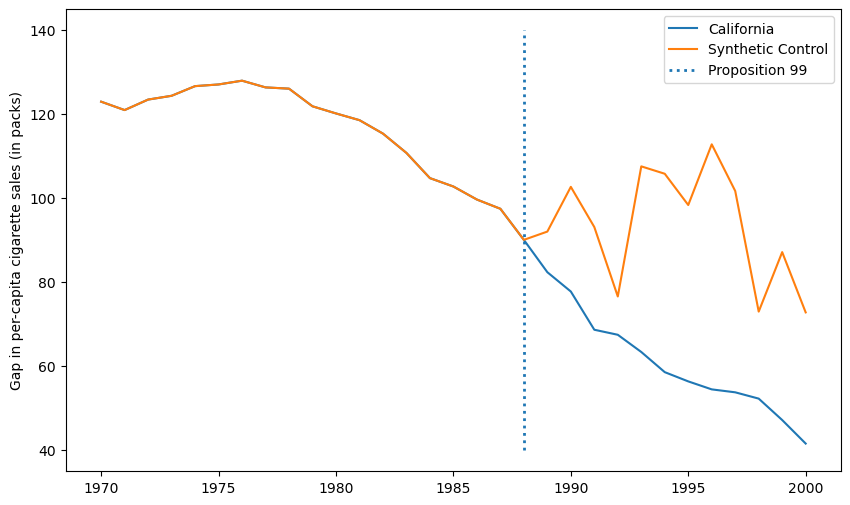

In [201]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

In [203]:
# the problem is overfitting, because our linear regression has 38 states as parameters to play with in order to make the pretreatment pool match the treatment as close as it can

# yep, we can use l1, l2 loss to regularize, but traditional method is:
# so we want to minimize the difference between X1 and X0, 
# X1 is a vector of pre-treatment characteristics of the treated unit and 
# X0 is a matrix of the corresponding characteristics of the control units3
# we add a weight matrix for X0 then to minimize X1 - dot(W, X0)
# we can use partitial derivatives of maximum likelihood for this
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000007458


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [204]:
# we got the weight, then we can multiply thsoe weights by the stats 
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

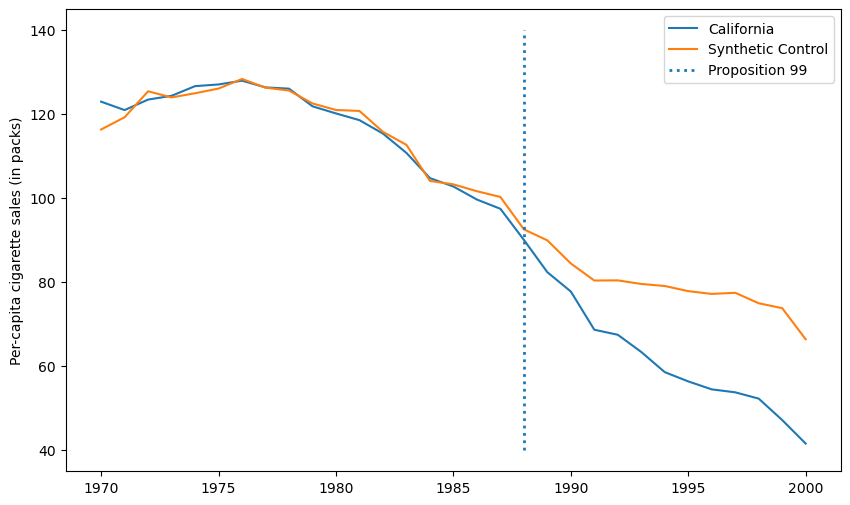

In [205]:
# do a plot
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

In [206]:
# 2. we can make inference

# first we need Fisher's Exact Test to permute the treated and control exhaustively 
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [207]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


In [208]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [209]:
synthetic_states[0].head()# with the synthetic control for all the states, we can estimate the gap
# between the synthetic and the true state for all states
# for california, it is ATE, for others, this is like a placebo effect
# where we estimate the synthetic control treatment effect where the treatment didnt actually happen

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


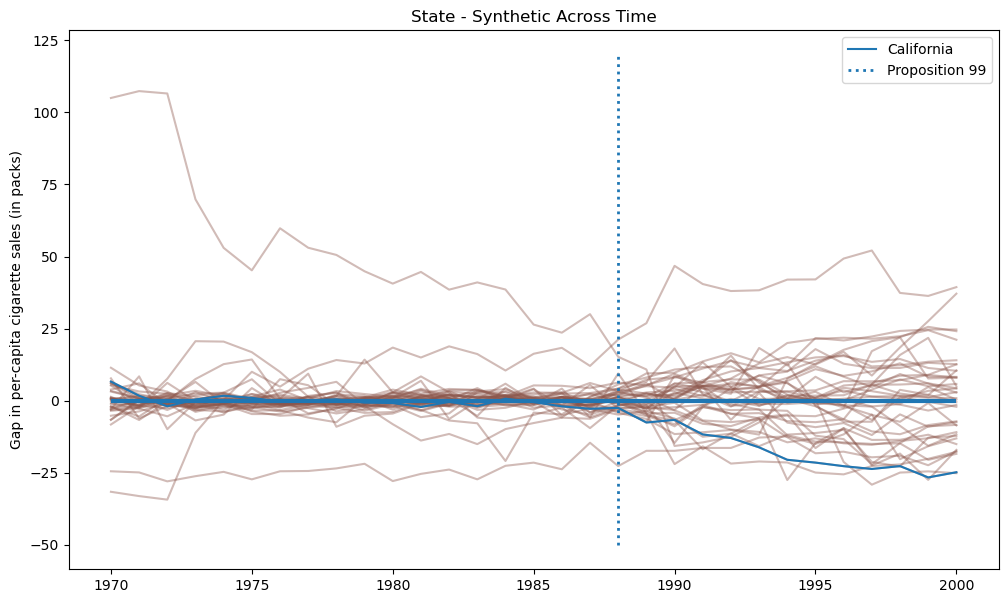

In [210]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

# the variance after the intervention is higher than before the intervention, this is since the synthetic control is designed
# to minimize the diff in the pre intervention period

# there are some units we cant fit very well even in the preintervention period, this is also to be expected, since
# if some states have very high cigarette consumption, no convex combination of the other states will ever match them
# but we can still set a threshold for pre intervention error using MSE

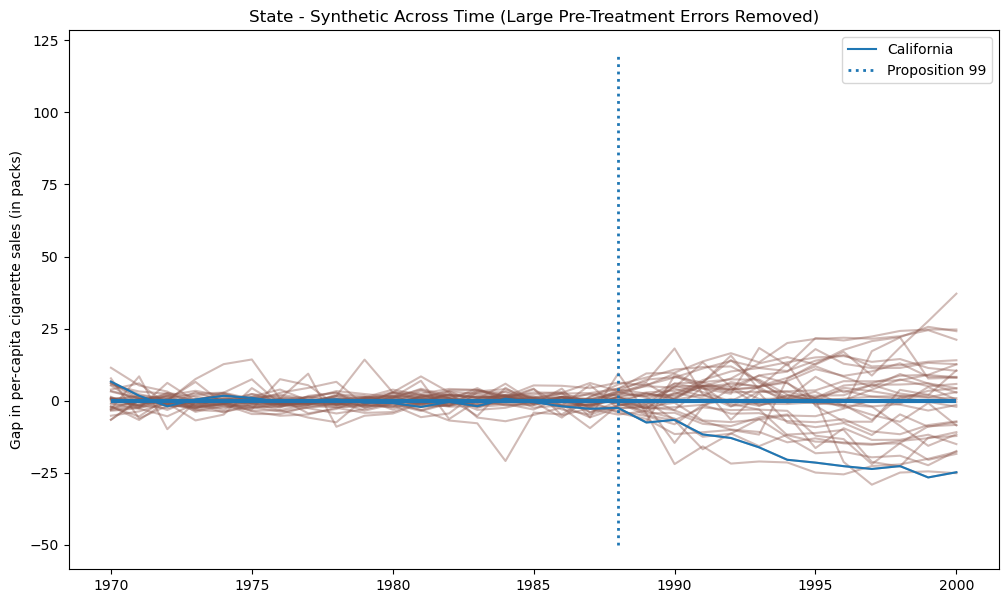

In [211]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

In [212]:
# perform p value
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)# ATE -24

California Treatment Effect for the Year 2000: -24.83015975492409


array([  5.79715885,   0.89458997, -24.83015975,  -7.16628121,
       -10.92204857,  37.11640557, -15.06971695,  -0.49805108,
       -18.45795062,  21.13366444,  12.57782771,  -1.47547827,
        10.49627353, -11.6701235 ,   4.29850824,   8.04811405,
        14.02322417,   8.25002748,   0.32576356,  -8.40826855,
        -2.12402704,  -7.42865016,   2.9615753 ,  24.10478116,
         4.25211769, -17.75844573,   7.93334016,   2.81640126,
        12.6495596 , -17.47677512, -25.16040937, -12.26469121,
        24.69067369,  10.36299581,  -8.59880336])

In [213]:
# we can estimate the P-value as the proportion of times the effect in California is bigger than all the estimated effects.
np.mean(np.array(effects) < calif_effect)# so it is significant

0.02857142857142857

In [ ]:
# 3. to summarize the steps of synthetic control
# a. define treatment and placebo, choose outcome
# b. each individual as a variable, choose before treatment data, every year is a row, then run linear regression
# c. we get the weights of each variable(states), but it can be overfitting, then we use maximum likelihood with partial
# derivatives to perform to get weights again
# d. now we just got the synthetic for the state we are interested in, we also need to have for all states, do the same thing in c
# e. use mse to drop synthetics with big gap
# f. compute ate and p value